<a href="https://colab.research.google.com/github/uujeongLee/CIFAR-10-Classification/blob/main/CIFAR_10_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
transforms_cifar10 = transforms.Compose(
                                  [transforms.Resize((32, 32)),
                                  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), #이미지 지터링(밝기, 대조, 채비, 색조)
                                  transforms.RandomHorizontalFlip(p=0.5), #p확률로 이미지 좌우반전
                                  transforms.RandomCrop(32, padding=4),
                                  transforms.ToTensor(), #모든 이미지를 tesor 형태로 바꾼다: numpy형태->torch의 tensor 형태
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])

transforms_cifar10_test = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


  car   car   car plane


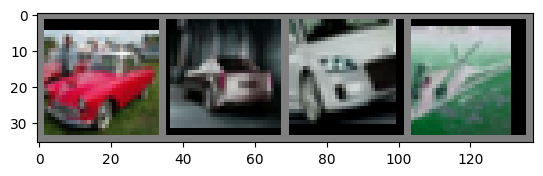

In [ ]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs[0:4,:,:,:]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
#SimpleNet 수정
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = SimpleNet().to(device)

In [ ]:
# VGG Model 변형

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

class own(nn.Module): #VGG 레이어수
    def __init__(self):
        super(own, self).__init__() #
        self.features = self.make_layers(cfg)
        self.classifier = nn.Linear(512, 10)

    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                nn.Dropout(0.4)
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(),
                           nn.BatchNorm2d(x)
                           ]
                in_channels = x
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


net = own().to(device)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
# Loss function and optimizer
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
lambda1 = lambda epoch: 0.98 ** epoch      # LambdaLR로 수정한 부분
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1) #lambdaLR scheduler

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
# Train the model
epochs = 50  # number of epochs

net.train() ##for Dropout

for epoch in range(epochs):

    loss_tmp = 0.0
    epoch_loss = 0.0

    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = loss_fun(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 40 == 39:    # Print loss every 40 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.5f' % (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.5f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

[Epoch - 1, Iteration -    40] Loss: 2.01052
[Epoch - 1, Iteration -    80] Loss: 0.82794
[Epoch - 1, Iteration -   120] Loss: 0.48408
[Epoch - 1, Iteration -   160] Loss: 0.33406
[Epoch - 1] Loss: 1.53438
[Epoch - 2, Iteration -    40] Loss: 1.07772
[Epoch - 2, Iteration -    80] Loss: 0.50846
[Epoch - 2, Iteration -   120] Loss: 0.31602
[Epoch - 2, Iteration -   160] Loss: 0.21492
[Epoch - 2] Loss: 0.95120
[Epoch - 3, Iteration -    40] Loss: 0.77048
[Epoch - 3, Iteration -    80] Loss: 0.36629
[Epoch - 3, Iteration -   120] Loss: 0.24323
[Epoch - 3, Iteration -   160] Loss: 0.17788
[Epoch - 3] Loss: 0.72540
[Epoch - 4, Iteration -    40] Loss: 0.62396
[Epoch - 4, Iteration -    80] Loss: 0.29955
[Epoch - 4, Iteration -   120] Loss: 0.20692
[Epoch - 4, Iteration -   160] Loss: 0.15145
[Epoch - 4] Loss: 0.60571
[Epoch - 5, Iteration -    40] Loss: 0.55394
[Epoch - 5, Iteration -    80] Loss: 0.26973
[Epoch - 5, Iteration -   120] Loss: 0.17451
[Epoch - 5, Iteration -   160] Loss: 0.13

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:      cat  ship  ship plane


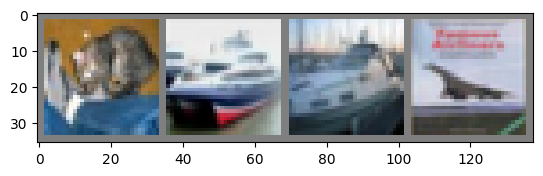

In [ ]:
# Test the trained model with sample
dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test[0:4,:,:,:]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# Test the trained model with overall test dataset
correct = 0
total = 0
with torch.no_grad():
  net.eval() #we do not use dropout
  for data in testloader:
    # Load the data
      inputs_test, labels_test = data
      inputs_test = inputs_test.to(device)
      labels_test = labels_test.to(device)

    # Estimate the output using the trained network
      outputs_test = net(inputs_test)
      _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
      total += labels_test.size(0)
      correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 59 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 77 %

Accuracy of the network on the 10,000 test images: 90 %
